In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import the pandas library with the alias 'pd'
import pandas as pd

# Loading the CSV file containing information about students

students = pd.read_csv('/content/drive/MyDrive/students.csv')

# Loading the CSV file containing information about mentors
mentors = pd.read_csv('/content/drive/MyDrive/mentor.csv')



In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# To Generate dummy data for illustration purposes
def generate_dummy_data(num_samples):
    input_dim = 34
    X_student = np.random.rand(num_samples, input_dim)
    X_mentor = np.random.rand(num_samples, input_dim)
    labels = np.random.randint(2, size=num_samples)
    return X_student, X_mentor, labels

# the base network
def base_network(input_shape):
    input = Input(shape=input_shape)
    x = Dense(128, activation='relu')(input)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    return Model(input, x)

# the Siamese Network
input_shape = (34,)
input_student = Input(shape=input_shape, name='input_student')
input_mentor = Input(shape=input_shape, name='input_mentor')

base_net = base_network(input_shape)
encoded_student = base_net(input_student)
encoded_mentor = base_net(input_mentor)

# distance metric (Euclidean distance)
distance = Lambda(lambda x: K.sqrt(K.sum(K.square(x[0] - x[1]), axis=1, keepdims=True)), name='distance')([encoded_student, encoded_mentor])

# Creating the Siamese Model
siamese_model = Model(inputs=[input_student, input_mentor], outputs=distance)

# Compiling the model with contrastive loss
siamese_model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['accuracy'])

# Generating dummy training data
num_train_samples = 1000
X_train_student, X_train_mentor, y_train = generate_dummy_data(num_train_samples)

# Training the Siamese Network
siamese_model.fit([X_train_student, X_train_mentor], y_train, epochs=10, batch_size=32, validation_split=0.2)

# Generating a sample student for matching
sample_student = np.random.rand(1, input_shape[0])

# Calculating similarity scores for the sample student with all mentors
similarity_scores = []
for mentor_data in X_train_mentor:
    mentor_data = mentor_data.reshape(1, -1)
    similarity_score = siamese_model.predict([sample_student, mentor_data])[0][0]
    similarity_scores.append(similarity_score)

# Normalize the similarity scores to obtain percentage-wise matching scores
normalized_scores = [(1 - score) * 100 for score in similarity_scores]

# the mentor with the highest matching score
best_mentor_index = np.argmax(normalized_scores)
best_mentor = X_train_mentor[best_mentor_index]

print(f"The best mentor for the sample student has a matching score of {normalized_scores[best_mentor_index]:.2f}%.")


Epoch 1/10
25/25 [==============================] - 1s 13ms/step - loss: 0.2604 - accuracy: 0.5300 - val_loss: 0.2619 - val_accuracy: 0.5000
Epoch 2/10
25/25 [==============================] - 0s 4ms/step - loss: 0.2296 - accuracy: 0.6125 - val_loss: 0.2625 - val_accuracy: 0.4700
Epoch 3/10
25/25 [==============================] - 0s 5ms/step - loss: 0.2089 - accuracy: 0.6775 - val_loss: 0.2641 - val_accuracy: 0.4800
Epoch 4/10
25/25 [==============================] - 0s 4ms/step - loss: 0.1935 - accuracy: 0.7538 - val_loss: 0.2641 - val_accuracy: 0.5250
Epoch 5/10
25/25 [==============================] - 0s 4ms/step - loss: 0.1839 - accuracy: 0.7825 - val_loss: 0.2704 - val_accuracy: 0.5150
Epoch 6/10
25/25 [==============================] - 0s 4ms/step - loss: 0.1764 - accuracy: 0.8000 - val_loss: 0.2770 - val_accuracy: 0.5050
Epoch 7/10
25/25 [==============================] - 0s 4ms/step - loss: 0.1669 - accuracy: 0.8300 - val_loss: 0.2808 - val_accuracy: 0.4850
Epoch 8/10
25/25 [=

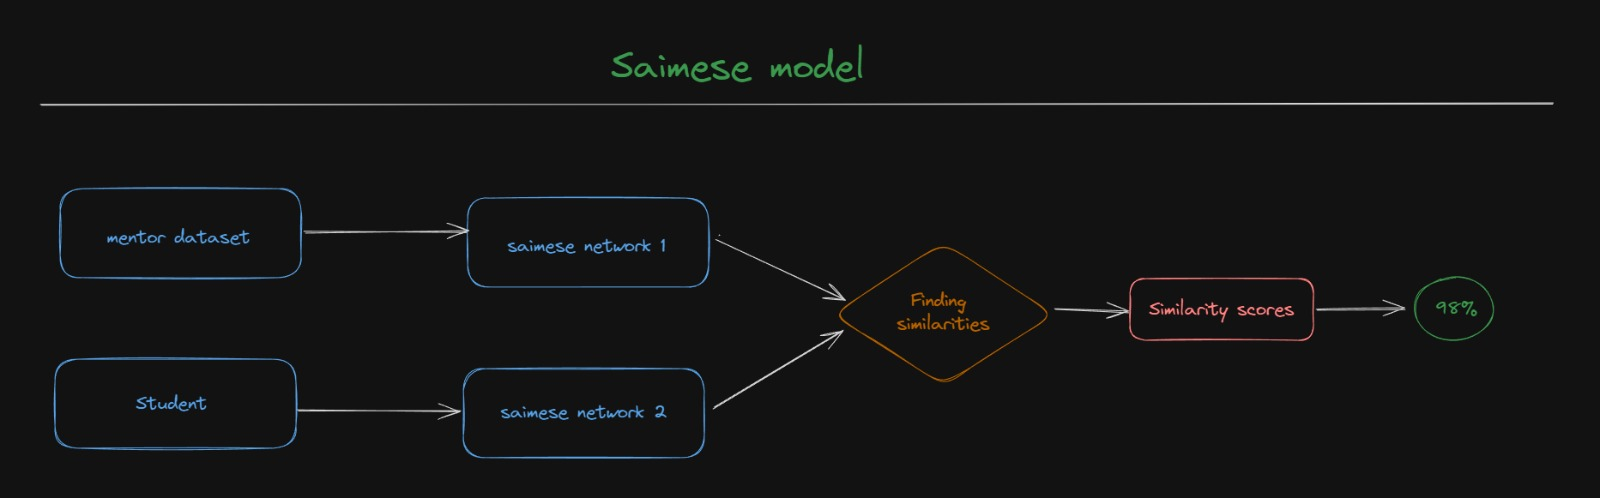

In [ ]:
# Saving the trained Siamese model
siamese_model.save('siamese_model.h5')

# Saving the base network separate
base_net.save('base_network.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
siamese_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_student (InputLayer)  [(None, 34)]                 0         []                            
                                                                                                  
 input_mentor (InputLayer)   [(None, 34)]                 0         []                            
                                                                                                  
 model (Functional)          (None, 32)                   14816     ['input_student[0][0]',       
                                                                     'input_mentor[0][0]']        
                                                                                                  
 distance (Lambda)           (None, 1)                    0         ['model[0][0]',         

In [ ]:
# importing necessary libraries
import numpy as np
from sklearn.datasets import make_spd_matrix
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

def generate_correlated_data(num_samples, num_features, correlation_strength=0.8):
    correlation_matrix = make_spd_matrix(num_features)
    X_student = np.random.multivariate_normal(mean=np.zeros(num_features), cov=correlation_matrix, size=num_samples)
    X_mentor = X_student + np.random.normal(scale=correlation_strength, size=(num_samples, num_features))
    X_student = np.clip(X_student, 0, 1)
    X_mentor = np.clip(X_mentor, 0, 1)
    labels = np.random.randint(2, size=num_samples)
    return X_student, X_mentor, labels

# here we have defined the function for finding top mentors:
def find_top_mentors_for_students(siamese_model, X_students, X_mentors, top_k=5):
    top_mentors_for_students = []

    for student_data in X_students:
        student_data = student_data.reshape(1, -1)

        similarity_scores = []
        for mentor_data in X_mentors:
            mentor_data = mentor_data.reshape(1, -1)
            similarity_score = siamese_model.predict([student_data, mentor_data])[0][0]
            similarity_scores.append(similarity_score)

        # Scaling similarity scores to the range [0, 100]
        scaled_scores = [score * 100 for score in similarity_scores]

        top_mentor_indices = np.argsort(scaled_scores)[:top_k]
        top_mentors = [X_mentors[idx] for idx in top_mentor_indices]
        top_mentor_scores = [scaled_scores[idx] for idx in top_mentor_indices]

        top_mentors_for_students.append({
            'student_data': student_data,
            'top_mentors': top_mentors,
            'top_mentor_scores': top_mentor_scores
        })

    return top_mentors_for_students



# Generating dummy data for illustration purposes
num_samples = 20
num_features = 34
correlation_strength = 0.8

X_students, X_mentors, _ = generate_correlated_data(num_samples, num_features, correlation_strength)

# Loading the base network and the trained Siamese model
base_net = load_model('/content/base_network.h5')
siamese_model = load_model('/content/siamese_model.h5')

# Defining the Siamese Network
input_shape = (num_features,)
input_student = Input(shape=input_shape, name='input_student')
input_mentor = Input(shape=input_shape, name='input_mentor')

# Using the base network layers and the siamese_model layers
base_net_student = base_net(input_student)
base_net_mentor = base_net(input_mentor)

# Distance layer
distance_layer = Lambda(lambda x: K.sqrt(K.sum(K.square(x[0] - x[1]), axis=1, keepdims=True)), name='distance')([base_net_student, base_net_mentor])

# Defining the new Siamese model
new_siamese_model = Model(inputs=[input_student, input_mentor], outputs=distance_layer)

# Compiling the new Siamese model
new_siamese_model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['accuracy'])

# To  find top 5 mentors for each student
top_mentors_results = find_top_mentors_for_students(new_siamese_model, X_students, X_mentors, top_k=5)

# Displaying the results
for i, result in enumerate(top_mentors_results):
    print(f"\nTop 5 mentors for Student {i + 1} (in descending order of similarity):")

    # Sorting mentors and scores in descending order of similarity
    sorted_indices = np.argsort(result['top_mentor_scores'])[::-1]
    sorted_mentors = [result['top_mentors'][idx] for idx in sorted_indices]
    sorted_scores = [result['top_mentor_scores'][idx] for idx in sorted_indices]

    for j, (mentor_data, similarity_score) in enumerate(zip(sorted_mentors, sorted_scores)):
        print(f"   Mentor {j + 1}: Similarity Score: {similarity_score:.2f}%")



1/1 [==============================] - 0s 35ms/step

Top 5 mentors for Student 1 (in descending order of similarity):
   Mentor 1: Similarity Score: 51.43%
   Mentor 2: Similarity Score: 50.75%
   Mentor 3: Similarity Score: 44.20%
   Mentor 4: Similarity Score: 39.87%
   Mentor 5: Similarity Score: 38.11%

Top 5 mentors for Student 2 (in descending order of similarity):
   Mentor 1: Similarity Score: 48.60%
   Mentor 2: Similarity Score: 46.80%
   Mentor 3: Similarity Score: 46.14%
   Mentor 4: Similarity Score: 43.54%
   Mentor 5: Similarity Score: 34.60%

Top 5 mentors for Student 3 (in descending order of similarity):
   Mentor 1: Similarity Score: 53.96%
   Mentor 2: Similarity Score: 52.54%
   Mentor 3: Similarity Score: 43.85%
   Mentor 4: Similarity Score: 43.51%
   Mentor 5: Similarity Score: 42.84%

Top 5 mentors for Student 4 (in descending order of similarity):
   Mentor 1: Similarity Score: 48.39%
   Mentor 2: Similarity Score: 47.69%
   Mentor 3: Similarity Score: 45.80%


In [ ]:
new_siamese_model.save('new_siamese_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
print(distance_layer)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='distance/Sqrt:0', description="created by layer 'distance'")


In [ ]:
print(siamese_model.inputs)
print(siamese_model.outputs)

[<KerasTensor: shape=(None, 34) dtype=float32 (created by layer 'input_student')>, <KerasTensor: shape=(None, 34) dtype=float32 (created by layer 'input_mentor')>]
[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'distance')>]


In [ ]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 46.4 MB/s eta 0:00:00


In [ ]:
# Now we can integrate our model to platform

import tensorflowjs as tfjs

In [ ]:
tfjs.converters.save_keras_model(new_siamese_model,"/content/drive/MyDrive/content")

In [ ]:
!ls

base_network.h5  group1-shard1of1.bin  new_siamese_model.h5  siamese_model.h5
drive		 model.json	       sample_data


In [ ]:
with open('model.json', 'r') as file:
    model_json = file.read()

print(model_json)


{"format": "layers-model", "generatedBy": "keras v2.15.0", "convertedBy": "TensorFlow.js Converter v4.17.0", "modelTopology": {"keras_version": "2.15.0", "backend": "tensorflow", "model_config": {"class_name": "Functional", "config": {"name": "model_6", "trainable": true, "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 34], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_student"}, "name": "input_student", "inbound_nodes": []}, {"class_name": "InputLayer", "config": {"batch_input_shape": [null, 34], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_mentor"}, "name": "input_mentor", "inbound_nodes": []}, {"class_name": "Functional", "config": {"name": "model_3", "trainable": true, "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 34], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_2"}, "name": "input_2", "inbound_nodes": []}, {"class_name": "Dense", "config": {"name"

In [ ]:
from google.colab import files

In [ ]:
# this downloaded file will be utilized further for model integration
files.download("model.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!tensorflowjs_converter --input_format keras /content/siamese_model.h5 /content

2024-02-17 17:33:34.516058: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 17:33:34.516135: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 17:33:34.517553: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-17 17:33:35.830693: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
node match.js
